# imports

In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap
import itertools
import random
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point
from schlichtanders.mymeta import proxify
from schlichtanders.mycontextmanagers import ignored

In [4]:
from IPython.display import IFrame
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

In [9]:
from schlichtanders.myobjects import NestedNamespace

# Simple Posterior

For testing we choose a conjugate likelihood/prior combination such that the resulting posterior form is known in advance.

It seems the only combination with commonly known results is Gauss, considering that we need a distribution which can be expressed as a function of some standard random source, because of stochastic backpropagation.

As the final goal is to have more complex distributions than Gaussians, another distribution might

In [ ]:
prior_u = 0
prior_s2 = 0.5

likelihood_s2 = 2

sample = np.random.normal(size=100, scale=4, loc=5)

posterior_s2 = 1 / (1/prior_s2 + len(sample)/likelihood_s2)
posterior_u = (prior_u/prior_s2 + sample.sum()/likelihood_s2) * posterior_s2

In [ ]:
posterior_u, posterior_s2

In [ ]:
likelihood = tm.Merge(pm.Gauss(init_var=likelihood_s2),
                      ignore_references={'parameters_positive'})
likelihood

In [ ]:
q = pm.Gauss()
q

In [ ]:
prior = tm.fix_params(pm.Gauss(init_mean=prior_u, init_var=prior_s2))
prior

In [ ]:
model = tm.variational_bayes(likelihood, 'parameters', q, priors=prior)
model

In [ ]:
_params = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
flat_parameters = tm.prox_flatten(tm.prox_center(model['parameters'] + _params))
flat_parameters

In [ ]:
tm.d3viz(([flat_parameters] + model.logP['inputs'], model.logP['outputs']), 'tmp/model.html')
IFrame('tmp/model.html', width=700, height=500)

In [ ]:
tm.reduce_all_identities()

In [ ]:
loss = tm.loss_variational(model)
optimizer_kwargs = tm.numericalize(
    loss, flat_parameters,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=0.01),
)
climin_args = izip(imap(lambda x:(x,), itertools.repeat(sample)), itertools.repeat({}))

In [ ]:
next(climin_args)

In [ ]:
opt = optimizer(
    identifier="adadelta",
#     steprate=1e-6,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

In [ ]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
best_params = None
last_best_i = opt.n_iter

In [ ]:
plt.figure()
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]

In [ ]:
for info in opt:
    loss = optimizer_kwargs['num_loss'](opt.wrt, sample)
    if opt.n_iter - last_best_i > 300:
        break
    if loss < best_loss:
        last_best_i = opt.n_iter
        best_loss = loss
        best_params = opt.wrt
        add_point(h_best, opt.n_iter, best_loss)
    add_point(h, opt.n_iter, loss)

In [ ]:
best_loss

In [ ]:
params = q['parameters'] + q['parameters_positive']
f_q_param = theano.function([flat_parameters], params)

In [ ]:
zip(map(str, params), f_q_param(best_params))

We fortunately get roughly the parameters of the posterior. The variance seems overestimated, always, but still fine. Kind of a factor of two.

# Complex Posterior Normflows

In [62]:
x = tm.as_tensor_variable([0.5]) #T.vector()
y = x + 0.3 * T.sin(2*np.pi*x)
func = tm.Model(inputs=[x], outputs=y, name="sin")

In [63]:
f = func.function()

<IPython.core.display.Javascript object>


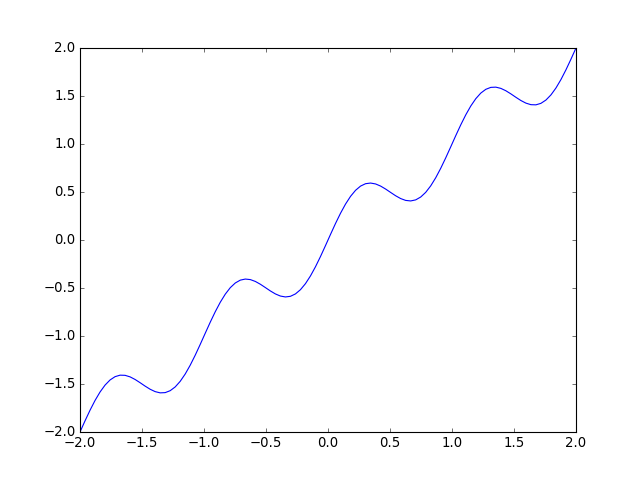

In [64]:
plt.figure()
num_x = np.linspace(-2, 2, 100)
plt.plot(num_x, [f([_num_x]) for _num_x in num_x])

In [65]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

Merge20 { 'inputs': [TensorConstant{(1,) of 0.5}], 'outputs': GaussianNoise5.outputs}

In [66]:
sampler = likelihood.function()
data = np.array([sampler([0.65]) for n in range(5000)])

<IPython.core.display.Javascript object>


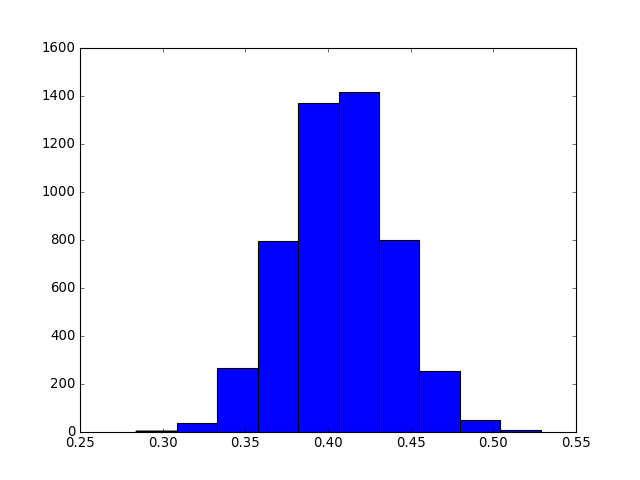

(array([    4.,    37.,   265.,   796.,  1372.,  1416.,   800.,   255.,
           48.,     7.]),
 array([ 0.28400425,  0.30848069,  0.33295713,  0.35743357,  0.38191002,
         0.40638646,  0.4308629 ,  0.45533934,  0.47981579,  0.50429223,
         0.52876867]),
 <a list of 10 Patch objects>)

In [67]:
plt.figure()
plt.hist(data)

---

In [68]:
prior = tm.fix_params(pm.DiagGauss(1, init_var=[1]))
# base_posterior = tm.fix_params(pm.DiagGauss(1))
base_posterior = pm.DiagGauss(1)
posterior = base_posterior
# transform_posteriors = [dm.PlanarTransform() for _ in range(4)] + [dm.LocScaleTransform()]
transform_posteriors = [dm.RadialTransform() for _ in range(4)]
for tr in transform_posteriors:
    posterior = tm.normalizing_flow(tr, posterior)
model = tm.variational_bayes(likelihood, 'inputs', posterior, priors=prior)

In [69]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()

_params = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
centred = tm.prox_center(model['parameters'] + _params)
flat = tm.prox_flatten(centred)

In [70]:
model

variational_lower_bound5 { 'inputs': [],
  'kl_prior': variational_lower_bound5.kl_prior,
  'logposterior': variational_lower_bound5.logposterior,
  'logprior': variational_lower_bound5.logprior,
  'n_data': n_data,
  'norm_det': RadialTransform24.norm_det,
  'outputs': GaussianNoise5.outputs,
  'parameters': [ z024_centered,
                  z023_centered,
                  z022_centered,
                  z021_centered,
                  mean_centered],
  'parameters_positive': [ alpha24_reparam,
                           beta+alpha24_reparam,
                           alpha23_reparam,
                           beta+alpha23_reparam,
                           alpha22_reparam,
                           beta+alpha22_reparam,
                           alpha21_reparam,
                           beta+alpha21_reparam,
                           var_reparam]}

In [71]:
batch_size = 10
n_batches = len(data) // batch_size
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=itertools.cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=1),
)

# climin_args = izip(imap(lambda x:(x,), itertools.repeat(data)), itertools.repeat({}))
climin_args = izip(imap(lambda x:(x,), chunk(batch_size, itertools.cycle(data))), itertools.repeat({}))

opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

In [72]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, data)
best_params = None
last_best_i = opt.n_iter // n_batches

<IPython.core.display.Javascript object>


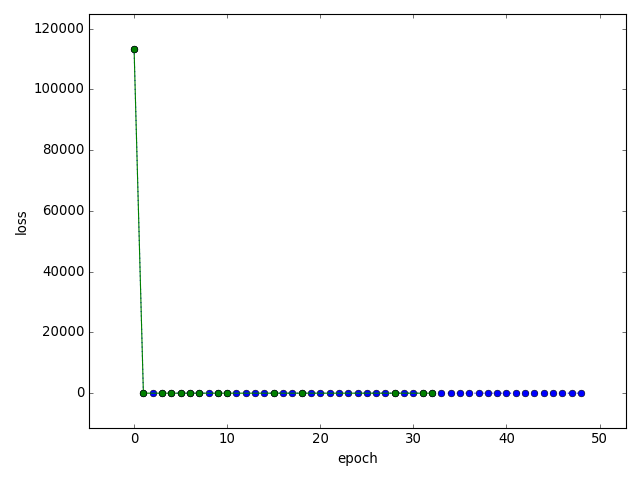

In [73]:
plt.figure()
# plt.yscale('log')
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]
plt.ylabel("loss")
plt.xlabel("epoch")

In [74]:
with ignored(KeyboardInterrupt):
    for info in every(n_batches, opt):
        current_epoch = opt.n_iter // n_batches
        _loss = optimizer_kwargs['num_loss'](opt.wrt, data)
        if current_epoch - last_best_i > 30:
            break
        if _loss < best_loss:
            last_best_i = current_epoch
            best_loss = _loss
            best_params = opt.wrt
            add_point(h_best, current_epoch, best_loss)
        add_point(h, current_epoch, _loss)

In [75]:
best_loss

-2.0366130213644107

In [76]:
posterior_sampler = theano.function([flat], posterior['outputs'])

<IPython.core.display.Javascript object>


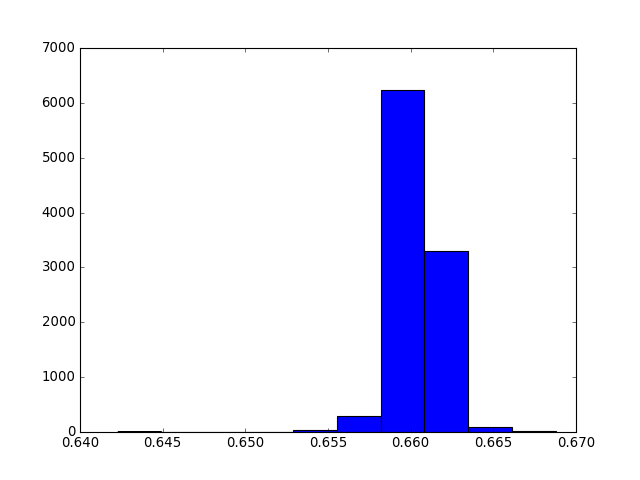

In [77]:
plt.figure()
plt.hist(np.array([posterior_sampler(best_params) for _ in range(10000)]))
pass

This seems as if it cannot find the two/three modes of the underlying posterior 

# Complex Posterior Mixture

In [ ]:
x = tm.as_tensor_variable([0.5]) #T.vector()
y = x + 0.3 * T.sin(2*np.pi*x)
func = tm.Model(inputs=[x], outputs=y, name="sin")

In [ ]:
likelihood = tm.Merge(pm.GaussianNoise(y, init_var=0.001), func, ignore_references={'parameters', 'parameters_positive'})
likelihood

In [ ]:
sampler = likelihood.function()
data = np.array([sampler([0.5]) for n in range(5000)])

---

In [ ]:
prior = tm.fix_params(pm.DiagGauss(1, init_var=[1]))
base_posteriors = [pm.DiagGauss(1) for _ in range(3)]
posterior =pm.Mixture(*base_posteriors)
model = tm.variational_bayes(likelihood, 'inputs', posterior, priors=prior)

In [ ]:
loss = tm.loss_variational(model)
tm.reduce_all_identities()

In [ ]:
_params = tm.prox_reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv)
_params += tm.prox_reparameterize(model['parameters_psumto1'], tm.softmax, tm.softmax_inv)
centred = tm.prox_center(model['parameters'] + _params)
flat = tm.prox_flatten(centred)

In [ ]:
flat

In [ ]:
tm.d3viz(loss, "tmp/loss.html")
IFrame("tmp/loss.html", width=700, height=700)

In [ ]:
batch_size = 10
n_batches = len(data) // batch_size
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)

optimizer_kwargs = tm.numericalize(loss, flat,
    batch_mapreduce=summap,
    annealing_combiner=tm.AnnealingCombiner(
        weights_regularizer=itertools.cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=1),
)

# climin_args = izip(imap(lambda x:(x,), itertools.repeat(data)), itertools.repeat({}))
climin_args = izip(imap(lambda x:(x,), chunk(batch_size, itertools.cycle(data))), itertools.repeat({}))

opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

In [ ]:
best_loss = optimizer_kwargs['num_loss'](opt.wrt, data)
best_params = None
last_best_i = opt.n_iter // n_batches

In [ ]:
plt.figure()
# plt.yscale('log')
h = plt.plot(last_best_i, best_loss, 'b:o')[0]
h_best = plt.plot(last_best_i, best_loss, 'g-o')[0]
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
with ignored(KeyboardInterrupt):
    for info in every(n_batches, opt):
        current_epoch = opt.n_iter // n_batches
        _loss = optimizer_kwargs['num_loss'](opt.wrt, data)
        if current_epoch - last_best_i > 30:
            break
        if _loss < best_loss:
            last_best_i = current_epoch
            best_loss = _loss
            best_params = opt.wrt
            add_point(h_best, current_epoch, best_loss)
        add_point(h, current_epoch, _loss)

In [ ]:
best_loss

In [ ]:
posterior_sampler = theano.function([flat], posterior['outputs'])

In [ ]:
plt.figure()
plt.hist(np.array([posterior_sampler(best_params) for _ in range(10000)]), bins=100)
pass

In [ ]:
f_mixture_probs = theano.function([flat], posterior.mixture_probs)
f_mixture_probs(best_params)

TODO test more noise on initial parameters

TODO check why normflows gives that low log-likelihoods (seems like a bad minima)